# Neural Network for Time-Stepping Prediction of Buildings

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.utils.data as data_utils
import os
import timeit

import matplotlib.pyplot as plt
import pandas as pd
import random
# import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler
import shap

from metaimnet import *

## Set Inputs

In [2]:
seed = 7               # Set seed. Keep this constant for reproducibility.
n_samples = 10000      # How many samples do we keep for training + validation (rest will be used for testing)
num_metaims = 5        # How many meta-IMs do we want to extract from the hazard time history?

In [3]:
path_to_predictor_dataset = 'predictors_new.parquet'           # Set the path to your analysis data file (csv/parquet)
path_to_processed_time_histories = '../../RC_Frame_large/x_gm'                  # Set the path to your ground motions file

## Read Inputs

In [4]:
cols2read = ['storeys', 'bays', 'storey_ht', 'bay_width', 'w_floor', 
             'f_c', 'gm_index', 'pga', 'pgv', 'drift_ratio_pct_max', 'damage_state']

predictors_all = pd.read_parquet(path_to_predictor_dataset, columns = cols2read, engine = 'pyarrow')

# Eliminate Outliers
# predictors_all = predictors_all[predictors_all['tip_displacement']<48].reset_index(drop = True)

predictors_all['building_ht'] = predictors_all['storeys'] * predictors_all['storey_ht']
predictors_all['building_width'] = predictors_all['bays'] * predictors_all['bay_width']

In [5]:
# # capacity = predictors_all['tip_displacement'].quantile(0.95)
# capacity = 24
# predictors_all['capacity'] = capacity
# predictors_all['damage_state'] = 0

# predictors_all.loc[predictors_all['tip_displacement']>predictors_all['capacity'], 'damage_state'] = 1

# predictors_all = predictors_all.drop(columns = ['storeys', 'storey_ht', 'bays', 'bay_width', 'capacity'])

In [6]:
predictors_all

,storeys,bays,storey_ht,bay_width,w_floor,f_c,gm_index,pga,pgv,drift_ratio_pct_max,damage_state,building_ht,building_width
0,5.0,5.0,189.327471,332.412195,38.902955,4.726132,20356,0.513863,9.107882,2.222651,0,946.637355,1662.060976
1,3.0,4.0,145.663176,315.766524,34.531060,5.334788,20356,0.513863,9.107882,1.058822,0,436.989527,1263.066095
2,5.0,4.0,158.654065,279.827897,26.935494,4.444108,20356,0.513863,9.107882,1.008116,0,793.270327,1119.311589
3,4.0,3.0,178.555998,302.398161,27.355257,5.548344,20356,0.513863,9.107882,1.184241,0,714.223990,907.194484
4,3.0,3.0,156.370057,308.946718,33.075264,5.056439,18405,0.783319,38.608344,11.639159,1,469.110170,926.840153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87174,3.0,3.0,181.726423,282.145888,23.362723,4.912726,12671,0.876193,44.533604,2.871762,1,545.179270,846.437663
87175,3.0,3.0,164.984614,279.128558,22.624270,4.688643,13989,1.389584,53.263963,9.865652,1,494.953841,837.385673
87176,3.0,3.0,170.123575,262.318536,24.453956,5.284058,1497,1.405091,56.204618,23.866986,1,510.370726,786.955607
87177,5.0,4.0,159.737362,256.205778,22.501874,4.951435,13401,0.779375,34.040481,19.153058,1,798.686811,1024.823110


## Prepare training data

In [7]:
train_data, val_data, test_data = create_train_val_test_splits(predictors_all, 
                                                               n_samples = n_samples, 
                                                               split_frac = 0.9, 
                                                               random_seed = seed)

cols2scale = ['building_ht', 'building_width', 'w_floor', 'f_c']
cols_predicted = ['damage_state']

x_train_scaled, x_val_scaled, x_test_scaled, y_data, y_val, y_test = create_scaled_inputs_outputs(train_data, 
                                                                                                  val_data, 
                                                                                                  test_data, 
                                                                                                  cols2scale)


## Prepare ground motion features

In [8]:
x_th_all = torch.load(path_to_processed_time_histories)

In [9]:
train_data, val_data, test_data, x_th, x_th_val, x_th_test = split_ground_motions(x_th_all, 
                                                                                  train_data, 
                                                                                  val_data, 
                                                                                  test_data)

In [10]:
x_th_all

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [11]:
del x_th_all

In [12]:
len(train_data['gm_index'].unique())

7714

## Train Meta-IMNet

In [13]:
# best_f1 = 0
# best_threshold = 0.5
# for t in np.linspace(0.1, 0.9, 50):
#     preds = (model_outputs > t).astype(int)
#     score = f1_score(true_labels, preds)
#     if score > best_f1:
#         best_f1 = score
#         best_threshold = t

In [14]:
max_epochs = 400
interval = 50

start = timeit.default_timer()
model1, model2, error_evolution_training, error_evolution_val = train_metaimnet_model(x_train_scaled, 
                                                                                   x_val_scaled, 
                                                                                   y_data, 
                                                                                   y_val, 
                                                                                   x_th, 
                                                                                   x_th_val, 
                                                                                   train_data, 
                                                                                   val_data, 
                                                                                   cols2scale,
                                                                                   num_metaims,
                                                                                   max_epochs,
                                                                                   automate_stopping = False,
                                                                                   interval = interval,
                                                                                   random_seed = seed,
                                                                                   alpha1 = 1e-03,
                                                                                   alpha2 = 1e-03,
                                                                                   nlayers1 = 4,
                                                                                   nhidden1 = 256,
                                                                                   nlayers2 = 3,
                                                                                   nhidden2 = 24)

stop = timeit.default_timer()

print('Time Elapsed in Model Training: ', stop - start)

Epoch 1: Training BCE Loss 0.8307, Validation BCE Loss 0.8287
Epoch 50: Training BCE Loss 0.4748, Validation BCE Loss 0.5124
Epoch 100: Training BCE Loss 0.4239, Validation BCE Loss 0.4624
Epoch 150: Training BCE Loss 0.3951, Validation BCE Loss 0.4486
Epoch 200: Training BCE Loss 0.3678, Validation BCE Loss 0.4296
Epoch 250: Training BCE Loss 0.3456, Validation BCE Loss 0.4074
Epoch 300: Training BCE Loss 0.3284, Validation BCE Loss 0.4182
Epoch 350: Training BCE Loss 0.3186, Validation BCE Loss 0.4243
Epoch 400: Training BCE Loss 0.3094, Validation BCE Loss 0.4324
Time Elapsed in Model Training:  386.584784203209


In [15]:
metaim_train, y_pred_train = predict_metaimnet(model1, model2, x_th, x_train_scaled, train_data)
metaim_val, y_pred_val = predict_metaimnet(model1, model2, x_th_val, x_val_scaled, val_data)

for i in range(num_metaims):
    train_data['meta_im_{}'.format(i)] = metaim_train[:,i].detach().numpy()
train_data['damage_state_pred'] = y_pred_train.detach().view(-1).numpy()
train_data['damage_state_class_pred'] = train_data['damage_state_pred'].round().astype("int")

for i in range(num_metaims):
    train_data['meta_im_{}'.format(i)] = metaim_train[:,i].detach().numpy()
val_data['damage_state_pred'] = y_pred_val.detach().view(-1).numpy()
val_data['damage_state_class_pred'] = val_data['damage_state_pred'].round().astype("int")

In [16]:
x_th.shape

torch.Size([7714, 20000])

## Distribution of responses

,Survived,Failed
Survived,0.937833,0.062167
Failed,0.080092,0.919908


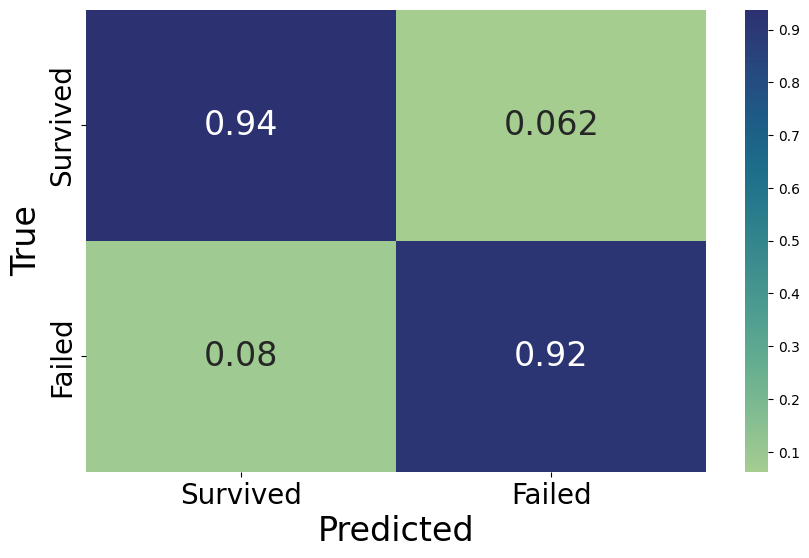

In [17]:
# constant for classes
classes = ('Survived', 'Failed')
plot_confusion(val_data, 'damage_state', 'damage_state_class_pred', classes)

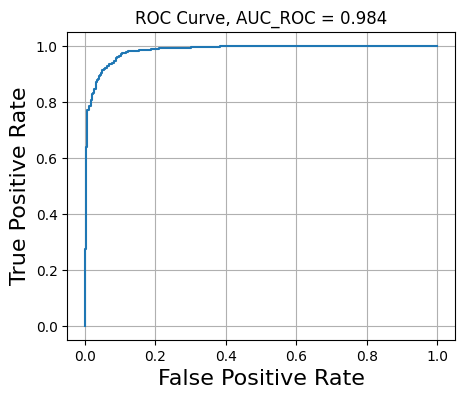

In [18]:
plot_auc_roc(val_data, 'damage_state', 'damage_state_pred')

,Survived,Failed
Survived,0.966397,0.033603
Failed,0.043390,0.956610


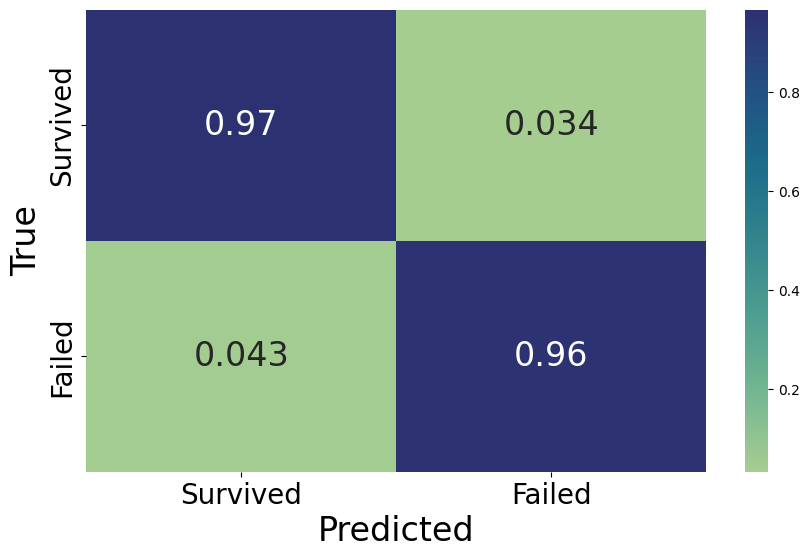

In [19]:
plot_confusion(train_data, 'damage_state', 'damage_state_class_pred', classes)

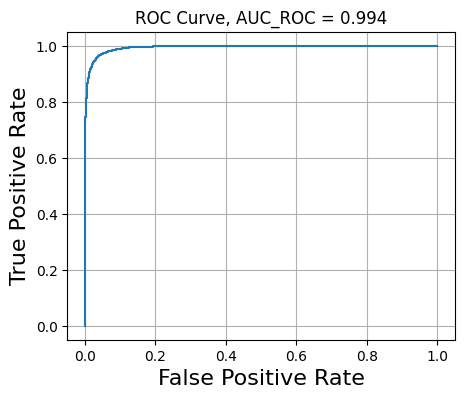

In [20]:
plot_auc_roc(train_data, 'damage_state', 'damage_state_pred')

In [21]:
accuracy_score(np.array(train_data['damage_state']), np.array(train_data['damage_state_class_pred']))

0.9621111111111111

## Loss Evolution

In [22]:
window_size = interval
epoch_count = np.array(range(window_size, len(error_evolution_training) + 1))
error_evolution_training = np.array(error_evolution_training)
error_evolution_training = np.convolve(error_evolution_training, 
                                       np.ones(window_size)/window_size, mode='valid')
error_evolution_val = np.array(error_evolution_val)
error_evolution_val = np.convolve(error_evolution_val, 
                                       np.ones(window_size)/window_size, mode='valid')

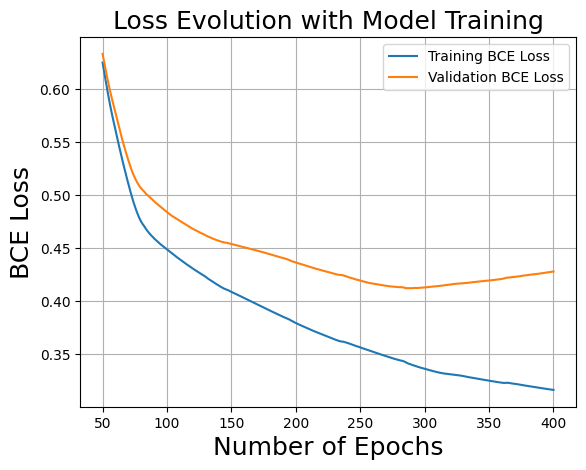

In [23]:
# Loss evolution curve
fig, ax = plt.subplots(1,1)
ax.plot(epoch_count, error_evolution_training, label = 'Training BCE Loss')
ax.plot(epoch_count, error_evolution_val, label = 'Validation BCE Loss')
# ax.plot(range(len(error_evolution_training)), error_evolution_training, label = 'Training BCE Loss')
# ax.plot(range(len(error_evolution_val)), error_evolution_val, label = 'Validation BCE Loss')
# ax.set(title="Loss Evolution with Model Training", xlabel="Number of Epochs", ylabel="MSE Loss")
ax.set_title("Loss Evolution with Model Training", fontsize = 18)
ax.set_xlabel("Number of Epochs", fontsize = 18)
ax.set_ylabel("BCE Loss", fontsize = 18)
ax.legend()
ax.grid()
plt.show()

## Make Predictions on Test Data

In [24]:
metaim_test, y_pred_test = predict_metaimnet(model1, model2, x_th_test, x_test_scaled, test_data)

for i in range(num_metaims):
    test_data['meta_im_{}'.format(i)] = metaim_test[:,i].detach().numpy()
test_data['damage_state_pred'] = y_pred_test.detach().view(-1).numpy()
test_data['damage_state_class_pred'] = test_data['damage_state_pred'].round().astype("int")

## Confusion Matrix on Test Data

,Survived,Failed
Survived,0.93969,0.06031
Failed,0.08140,0.91860


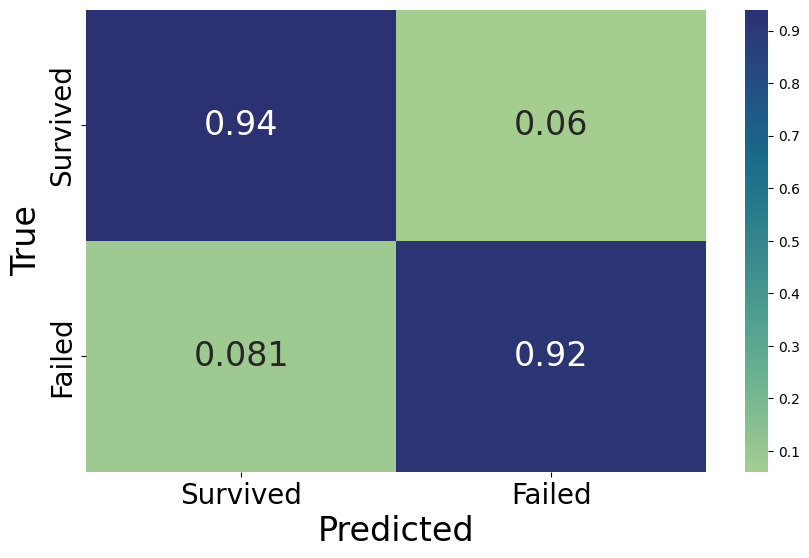

In [25]:
plot_confusion(test_data, 'damage_state', 'damage_state_class_pred', classes)

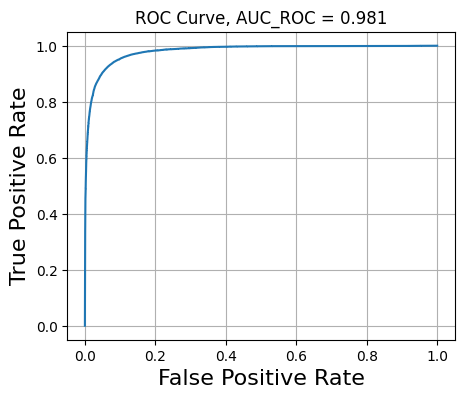

In [26]:
plot_auc_roc(test_data, 'damage_state', 'damage_state_pred')

In [27]:
accuracy_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.930525142849739

In [28]:
roc_auc_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_pred']))

0.9807114382310745

In [29]:
precision_score((test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.9212918660287082

In [30]:
recall_score((test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.9185997972449162

## Confusion Matrix on Combined Train, Validation, and Test Data

,Survived,Failed
Survived,0.942411,0.057589
Failed,0.077434,0.922566


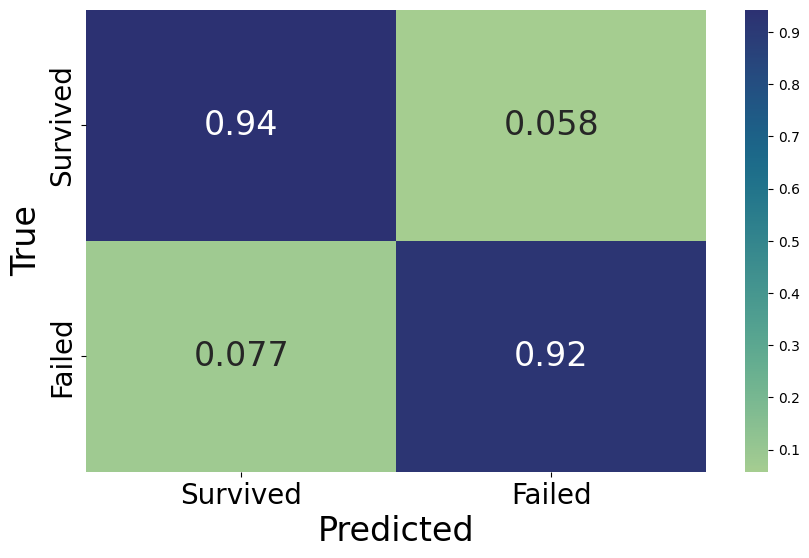

In [31]:
all_data = pd.concat([train_data, val_data, test_data]).reset_index(drop = True)
plot_confusion(all_data, 'damage_state', 'damage_state_class_pred', classes)

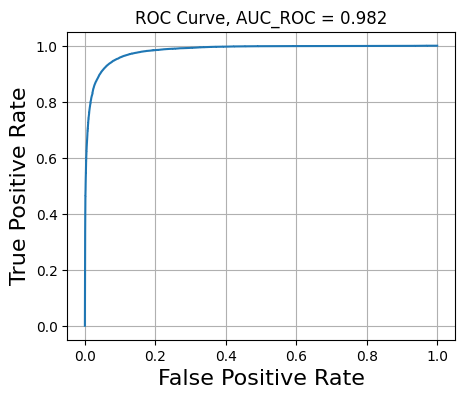

In [32]:
plot_auc_roc(all_data, 'damage_state', 'damage_state_pred')

In [33]:
# del train_data, val_data, test_data

## Compare Fragilities

In [34]:
fragility_df_high_fidelity = develop_fragility_model_stripe(predictors_all, 'pga', 'damage_state', bin_width = 0.1, max_im = 1.5)
fragility_df_pred = develop_fragility_model_stripe(all_data, 'pga', 'damage_state_class_pred', bin_width = 0.1, max_im = 1.5)

In [35]:
fragility_df_pred

,IM,Probability
0,0.05,0.00075
1,0.15,0.046006
2,0.25,0.159448
3,0.35,0.320066
4,0.45,0.447641
5,0.55,0.517524
6,0.65,0.56134
7,0.75,0.590312
8,0.85,0.628981
9,0.95,0.663542


In [36]:
fragility_df_high_fidelity

,IM,Probability
0,0.05,0.000125
1,0.15,0.050256
2,0.25,0.172881
3,0.35,0.318418
4,0.45,0.429886
5,0.55,0.512287
6,0.65,0.564525
7,0.75,0.599796
8,0.85,0.64117
9,0.95,0.671461


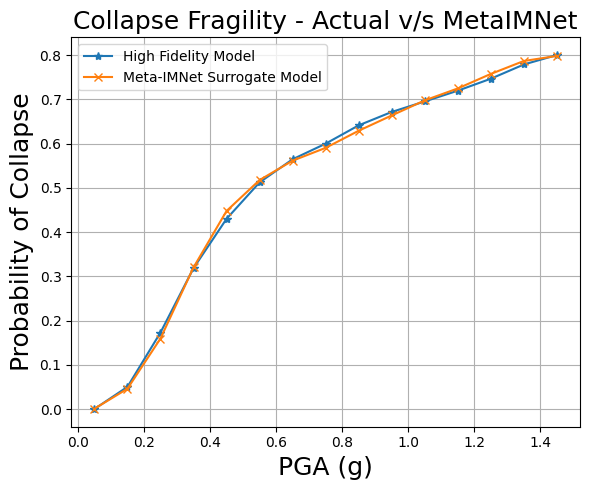

 Mean error = 0.008451, Max error = 0.017755


In [37]:
fig, ax = plt.subplots(1,1, figsize = (6, 5))

error_mean = (((fragility_df_high_fidelity['Probability'] - fragility_df_pred['Probability'])**2).mean())**0.5
error_max = (((fragility_df_high_fidelity['Probability'] - fragility_df_pred['Probability'])**2).max())**0.5

ax.plot(np.array(fragility_df_high_fidelity['IM']), np.array(fragility_df_high_fidelity['Probability']), '*-', label = 'High Fidelity Model')
ax.plot(np.array(fragility_df_pred['IM']), np.array(fragility_df_pred['Probability']), 'x-', label = 'Meta-IMNet Surrogate Model')
ax.legend()
ax.set_xlabel('PGA (g)', fontsize = 18)
ax.set_ylabel('Probability of Collapse', fontsize = 18)
ax.set_title('Collapse Fragility - Actual v/s MetaIMNet', fontsize = 18)
ax.grid()

plt.tight_layout()
plt.show()

print(' Mean error = {}, Max error = {}'.format(round(error_mean,6), round(error_max,6)))

In [38]:
all_data_high = all_data[all_data['pga']>1.3]
precision_score(np.array(all_data_high['damage_state']), 
               np.array(all_data_high['damage_state_class_pred']))

0.955090584332738

In [39]:
recall_score(np.array(all_data_high['damage_state']), 
               np.array(all_data_high['damage_state_class_pred']))

0.9587602459016393

In [40]:
# path_to_pga_dataset = '../../RC_Frame_large/pga_all_new.parquet'

# pga_all = pd.read_parquet(path_to_pga_dataset, engine = 'pyarrow')
# all_data_save = all_data.merge(pga_all[['sa01', 'sa02', 'sa03', 'sa06', 'sa10', 'sa150', 'sa20', 'arias', 'sed', 'cav', 'ASI_05', 'ASI_10']], 
#                                       left_on = 'gm_index', right_index = True)
# all_data_save.to_parquet('all_data_analysis.parquet', engine = 'pyarrow')

In [50]:
# fragility_df_pred.to_parquet('frag_df{}_metanet_{}.parquet'.format(num_metaims, seed), engine = 'pyarrow')

## Further Analysis

In [42]:
# # Predict using the trained model
# meta_im_cols = ['meta_im_{}'.format(i) for i in range(num_metaims)]
# x_th = torch.tensor(all_data[meta_im_cols].values)

# x_to_scale_train = torch.tensor(train_data[cols2scale].values)
# scaler = StandardScaler()
# scaler.fit(x_to_scale_train)

# x_to_scale = torch.tensor(all_data[cols2scale].values)
# x_scaled = torch.tensor(scaler.transform(x_to_scale))

# x_data_all = torch.cat((x_th, x_scaled), dim = 1)

# def predict_shap(x_data_all):
#     x_data_all = torch.tensor(x_data_all)
#     y_pred = model2(x_data_all.float()).detach().numpy()
    
#     return y_pred

In [43]:
# x_data_sampled = x_data_all[np.random.choice(x_data_all.shape[0], size=10, replace=False)]

# explainer = shap.KernelExplainer(predict_shap, np.array(x_data_sampled))
# shap_values = explainer.shap_values(np.array(x_data_all)[:10])

In [44]:
# feature_names = cols2scale + meta_im_cols

# shap.summary_plot(shap_values.squeeze(-1), 
#                   np.array(x_data_all)[:10], 
#                   feature_names=feature_names)

In [45]:
# shap_values = explainer.shap_values(np.array(x_data_all)[-1000:])

In [46]:
# shap.summary_plot(shap_values.squeeze(-1), 
#                   np.array(x_data_all)[-1000:], 
#                   feature_names=feature_names)

In [47]:
# # shap_values[53]
# shap_values = explainer.shap_values(np.array(x_data_all))

# shap.summary_plot(shap_values, x_data_all, feature_names=feature_names)

In [48]:
# import pickle

# # Example: model and scaler
# model_path = "memaimnet_5.pkl"

# save_dict = {
#     'model1_state_dict': model1.state_dict(),
#     'model2_state_dict': model2.state_dict(),
#     'scaler': scaler,  # e.g., StandardScaler from sklearn
#     'num_metaims': num_metaims,  # optional: to recreate the model
#     'random_seed': seed,         # optional: seed used, needed to split the dataset
# }

# # Save using pickle
# with open(model_path, 'wb') as f:
#     pickle.dump(save_dict, f)
